<a href="https://colab.research.google.com/github/blancosss21/F1-Driver-Performance-Analysis/blob/main/F1_Driver_Performance_Complete_Analysis_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation for Formula 1 Race Data

## Overview

This project involves the preparation and analysis of Formula 1 race data obtained from the Ergast API. The primary objective is to clean, transform, and visualize the race data from multiple seasons to derive insights into driver performance.

## Contents

- Data fetching and preparation
- Data cleaning and transformation
- Exploratory Data Analysis (EDA)
- Visualization of driver statistics

## Requirements

To run this project, you'll need to install the following Python packages:

- `pandas`
- `numpy`
- `matplotlib`
- `seaborn`
- `requests`
- `json`

You can install these packages using pip:

```bash
pip install pandas numpy matplotlib seaborn requests
```

This project is licensed under the MIT License - see the LICENSE file for details.


# Data Preparation

In [1]:
# Import all packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json

In [2]:
# Obtain race data from the Ergast API
def get_race_data(season):
    url = f"https://ergast.com/api/f1/{season}/results.json?limit=1000"
    response = requests.get(url)
    data = response.json()
    races = data['MRData']['RaceTable']['Races']
    return races

In [6]:
# Obtaining data for each season
all_races = []
for season in seasons:
    races = get_race_data(season)
    all_races.extend(races)

# Convert data into a pandas DataFrame
df = pd.json_normalize(all_races, 'Results',
                       ['season', 'round', 'raceName', 'date', ['Circuit', 'circuitName']],
                       record_prefix='_')

# Display available columns to verify the data
print(df.columns)

# Select only columns of interest
df = df[['_Driver.driverId', '_position', '_points', '_FastestLap.Time.time', '_FastestLap.rank', '_FastestLap.AverageSpeed.speed', '_Time.millis', '_Time.time', 'season', 'raceName', 'date', 'Circuit.circuitName']]

# Rename columns for better readability
df.columns = ['driverId', 'position', 'points', 'fastestLapTime', 'fastestLapRank', 'averageSpeed', 'totalTimeMillis', 'totalTime', 'season', 'raceName', 'date', 'circuitName']

# Convert columns to appropriate data types
df['position'] = pd.to_numeric(df['position'], errors='coerce')
df['points'] = pd.to_numeric(df['points'], errors='coerce')
df['fastestLapTime'] = pd.to_timedelta(df['fastestLapTime'], errors='coerce').dt.total_seconds()
df['averageSpeed'] = pd.to_numeric(df['averageSpeed'], errors='coerce')
df['totalTimeMillis'] = pd.to_numeric(df['totalTimeMillis'], errors='coerce')
df['totalTime'] = pd.to_timedelta(df['totalTime'], errors='coerce').dt.total_seconds()
df['date'] = pd.to_datetime(df['date'])

# Show the first rows of the clean DataFrame
print(df.head())

Index(['_number', '_position', '_positionText', '_points', '_grid', '_laps',
       '_status', '_Driver.driverId', '_Driver.permanentNumber',
       '_Driver.code', '_Driver.url', '_Driver.givenName',
       '_Driver.familyName', '_Driver.dateOfBirth', '_Driver.nationality',
       '_Constructor.constructorId', '_Constructor.url', '_Constructor.name',
       '_Constructor.nationality', '_Time.millis', '_Time.time',
       '_FastestLap.rank', '_FastestLap.lap', '_FastestLap.Time.time',
       '_FastestLap.AverageSpeed.units', '_FastestLap.AverageSpeed.speed',
       'season', 'round', 'raceName', 'date', 'Circuit.circuitName'],
      dtype='object')
   driverId  position  points  fastestLapTime fastestLapRank  averageSpeed  \
0    bottas         1      25             NaN              2       229.758   
1   leclerc         2      18             NaN              4       228.933   
2    norris         3      16             NaN              1       230.378   
3  hamilton         4      12  

#Displaying the Average Points per Race per Driver

<ipython-input-59-80b27090bca4>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='average_points', y='driverId', data=driver_stats, palette='coolwarm', dodge=False)


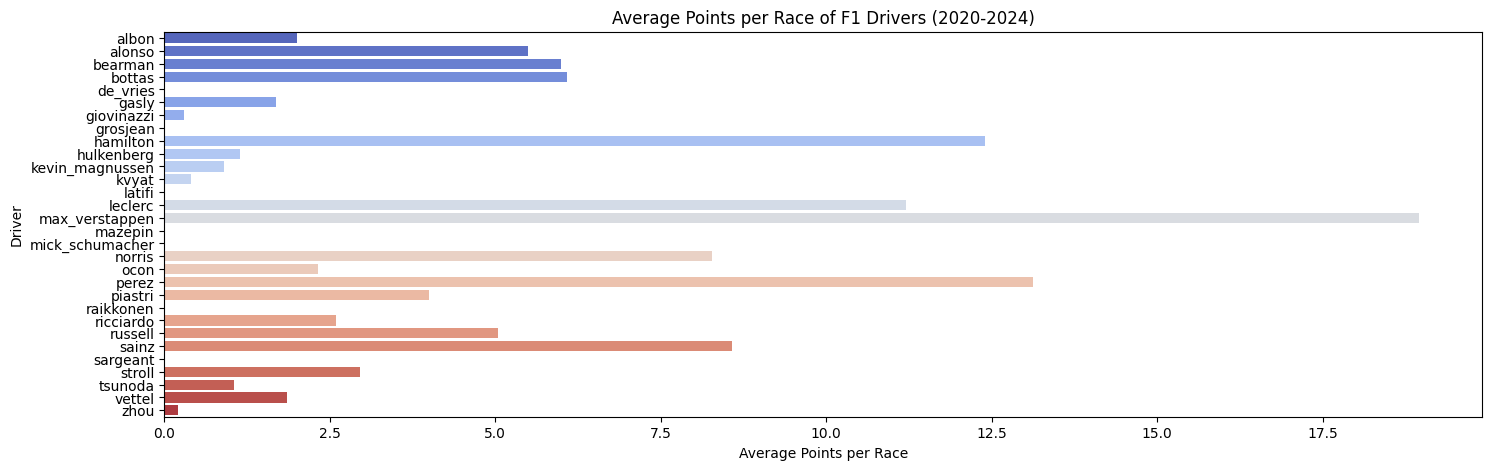

In [59]:
# Calculate the total points for each driver
driver_points = df.groupby('driverId')['points'].sum().reset_index()
driver_points.columns = ['driverId', 'total_points']

# Count the number of races for each driver
driver_races = df.groupby('driverId').size().reset_index(name='race_count')

# Merge the total points and race count
driver_stats = pd.merge(driver_points, driver_races, on='driverId', how='left')

# Calculate the average points per race
driver_stats['average_points'] = driver_stats['total_points'] / driver_stats['race_count']

# Displaying the Average Points per Race per Driver
plt.figure(figsize=(17, 5))
sns.barplot(x='average_points', y='driverId', data=driver_stats, palette='coolwarm', dodge=False)
plt.title('Average Points per Race of F1 Drivers (2020-2023)')
plt.xlabel('Average Points per Race')
plt.ylabel('Driver')
plt.show()


# Total Points per Driver

Empty DataFrame
Columns: [driverId, fastest_laps]
Index: []
   driverId  total_points  race_count  average_points  fastest_laps_x  \
0     albon            40          20            2.00             0.0   
1    alonso           110          20            5.50             0.0   
2   bearman             6           1            6.00             0.0   
3    bottas           152          25            6.08             0.0   
4  de_vries             0           5            0.00             0.0   

   fastest_laps_y  fastest_laps  fastest_laps_fastest  fastest_laps_fastest  
0             NaN           0.0                   NaN                   NaN  
1             NaN           0.0                   NaN                   NaN  
2             NaN           0.0                   NaN                   NaN  
3             NaN           0.0                   NaN                   NaN  
4             NaN           0.0                   NaN                   NaN  


<ipython-input-42-e07d9a389aad>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_points', y='driverId', data=driver_stats, dodge=False, palette='magma')


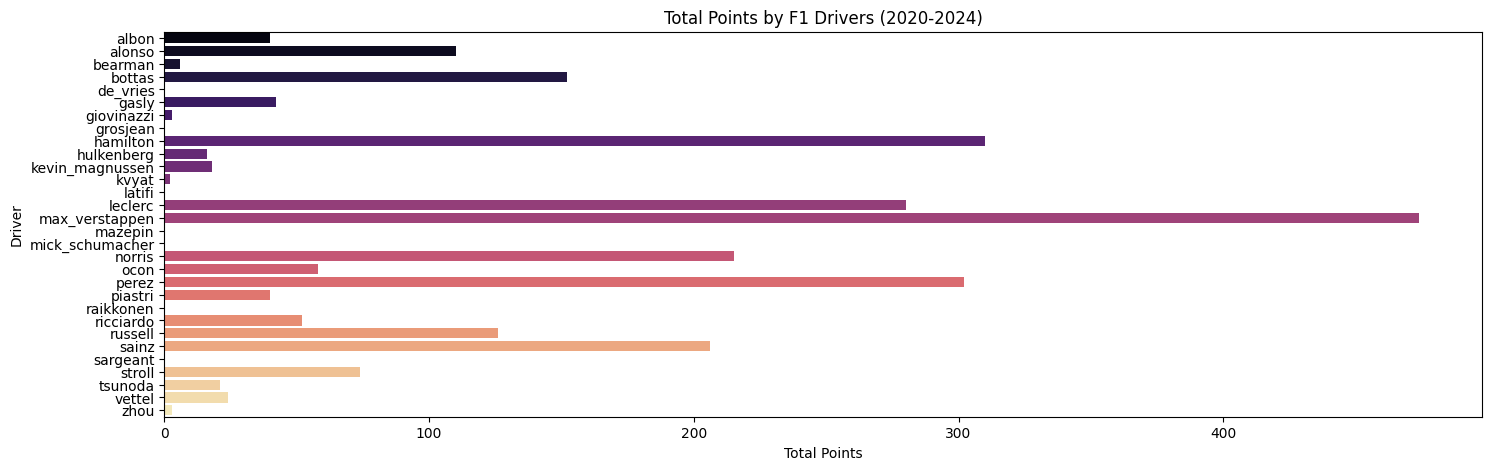

In [42]:
#Count the fastest laps for each driver
fastest_laps = df[df['fastestLapRank'] == 1].groupby('driverId').size().reset_index(name='fastest_laps')

# Print the fastest laps DataFrame to verify its contents
print(fastest_laps)

# Merge with driver statistics and avoid column name conflicts
driver_stats = pd.merge(driver_stats, fastest_laps, on='driverId', how='left', suffixes=('', '_fastest'))

# Fill NaN values with 0 for drivers without fastest laps
driver_stats['fastest_laps'] = driver_stats['fastest_laps'].fillna(0)

# Check driver_stats DataFrame after merging
print(driver_stats.head())

# Visualization of Fastest Laps per Driver, only for those with recorded laps
filtered_stats = driver_stats[driver_stats['fastest_laps'] > 0]

# If filtered_stats is empty, visualize total points instead
if filtered_stats.empty:
    plt.figure(figsize=(17, 5))
    sns.barplot(x='total_points', y='driverId', data=driver_stats, dodge=False, palette='magma')
    plt.title('Total Points by F1 Drivers (2020-2023)')
    plt.xlabel('Total Points')
    plt.ylabel('Driver')
    plt.show()
else:
    plt.figure(figsize=(17, 5))
    sns.barplot(x='fastest_laps', y='driverId', data=filtered_stats, dodge=False, palette='magma')
    plt.axvline(x=0, color='grey', linestyle='--')  # Horizontal line at zero for reference
    plt.title('Fastest Laps by F1 Drivers (2020-2023)')
    plt.xlabel('Fastest Laps')
    plt.ylabel('Driver')
    plt.show()


# Data Display

In [61]:
# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract the year from the date and create a new 'year' column
df['year'] = df['date'].dt.year

# Count the number of unique races per year using the 'raceName' column
race_count_per_year = df.groupby('year')['raceName'].nunique().reset_index(name='race_count')

# Display the first few rows of the DataFrame to confirm data presence
print(df.head())

# Check the total number of unique races in the dataset
total_races = df['raceName'].nunique()
print(f'Total unique races: {total_races}')

# Identify duplicate rows based on 'raceName' and 'date'
duplicates = df[df.duplicated(subset=['raceName', 'date'], keep=False)]
if not duplicates.empty:
    print(f'Duplicate races:\n{duplicates}')
else:
    print('No duplicate races found.')

# Display unique values in the 'season' column
print(f'Unique seasons: {df["season"].unique()}')

# Display DataFrame info and additional checks
print(df.info())  # Get information about the DataFrame, such as number of rows and columns



   driverId  position  points  fastestLapTime fastestLapRank  averageSpeed  \
0    bottas         1      25             NaN              2       229.758   
1   leclerc         2      18             NaN              4       228.933   
2    norris         3      16             NaN              1       230.378   
3  hamilton         4      12             NaN              3       229.572   
4     sainz         5      10             NaN              5       228.687   

   totalTimeMillis  totalTime season             raceName       date  \
0        5455739.0   5455.739   2020  Austrian Grand Prix 2020-07-05   
1        5458439.0        NaN   2020  Austrian Grand Prix 2020-07-05   
2        5461230.0        NaN   2020  Austrian Grand Prix 2020-07-05   
3        5461428.0        NaN   2020  Austrian Grand Prix 2020-07-05   
4        5464642.0        NaN   2020  Austrian Grand Prix 2020-07-05   

     circuitName  year  
0  Red Bull Ring  2020  
1  Red Bull Ring  2020  
2  Red Bull Ring  2020 

# Point Distribution Analysis

1. Understanding the Distribution:
X-Axis (Points): The points represent the scores that drivers earn based on their finishing positions in races. In Formula 1, points are awarded to the top finishers, with the most points going to the winner and decreasing for those finishing in lower positions. For example, as of the current scoring system:
1st place: 25 points
2nd place: 18 points
3rd place: 15 points
4th place: 12 points
5th place: 10 points
6th place: 8 points
7th place: 6 points
8th place: 4 points
9th place: 2 points
10th place: 1 point
Y-Axis (Frequency): This axis shows how many times each point value has occurred across all races in the dataset. The frequency indicates how often drivers have earned specific points.
2. Significance of the Distribution:
Performance Insights: The distribution provides insights into driver performance over the season or multiple seasons. A higher frequency of higher points suggests that certain drivers consistently finish in top positions, indicating strong performance.
Competitive Balance: Analyzing the spread can reveal how competitive the season was. For instance, a distribution with many drivers scoring similar points suggests a competitive field, while a distribution heavily skewed towards high scores for a few drivers could indicate dominance by a specific team or driver.
KDE (Kernel Density Estimation): The KDE curve superimposed on the histogram gives a smoothed representation of the distribution. This helps in identifying the underlying probability distribution of the points earned, highlighting the areas where most points are concentrated.
Strategic Decisions: Teams can analyze this distribution to understand where their drivers stand relative to competitors and adjust strategies accordingly. For example, if many races yield lower points, a team may focus on car performance improvements or race strategy adjustments.
3. Interpreting Specific Patterns:
Peaks: If there are significant peaks in the distribution (e.g., around 25 points, 18 points), it indicates that many drivers frequently finish in those positions.
Skewness: If the distribution is skewed to the right (with a long tail towards higher points), it suggests that while most drivers earn lower points, a few drivers achieve high scores frequently.
Bimodal Distribution: If there are two distinct peaks, this might indicate two groups of drivers: one consistently scoring high points and another scoring low to moderate points.

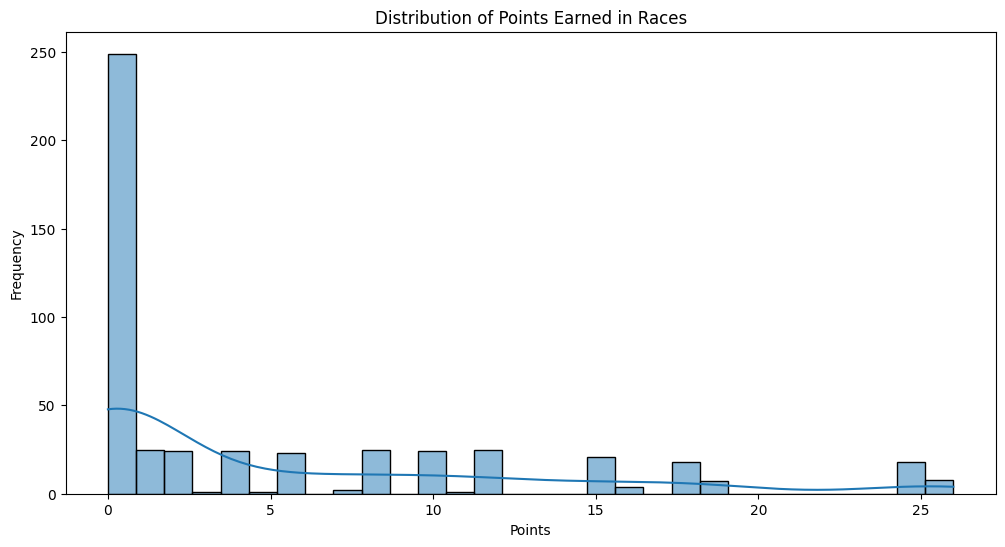

In [33]:
#Point Distribution Analysis
plt.figure(figsize=(12, 6))
sns.histplot(df['points'], bins=30, kde=True)
plt.title('Distribution of Points Earned in Races')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.show()

# Predicted Average Points per Driver (2024-2025)

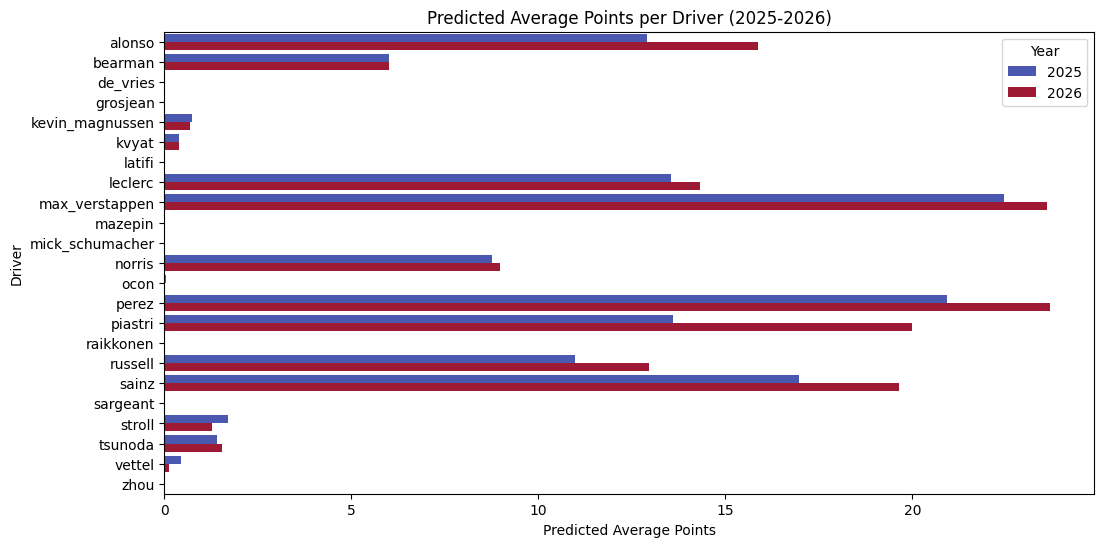

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Step 1: Prepare the data
# Ensure 'year' is in the DataFrame and properly formatted
df['year'] = pd.to_datetime(df['date']).dt.year

# Step 2: Create a time series of average points per driver per year
average_points_per_year = df.groupby(['driverId', 'year'])['points'].mean().reset_index()

# Step 3: Create a Linear Regression model for each driver
predictions = []
unique_drivers = average_points_per_year['driverId'].unique()

for driver in unique_drivers:
    driver_data = average_points_per_year[average_points_per_year['driverId'] == driver]
    X = driver_data['year'].values.reshape(-1, 1)  # Feature: Year
    y = driver_data['points'].values  # Target: Average Points

    # Create and fit the model
    model = LinearRegression()
    model.fit(X, y)

    # Step 4: Predict future years
    future_years = np.array([[2024], [2025]])
    predicted_points = model.predict(future_years)

    # Step 5: Append predictions
    for year, points in zip([2024, 2025], predicted_points):
        predictions.append({'driverId': driver, 'year': year, 'predicted_points': points})

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(predictions)

# Step 6: Filter predictions to include only those with predicted points >= 0
filtered_predictions_df = predictions_df[predictions_df['predicted_points'] >= 0]

# Step 7: Visualize predictions
plt.figure(figsize=(12, 6))
sns.barplot(x='predicted_points', y='driverId', hue='year', data=filtered_predictions_df, palette='coolwarm')
plt.title('Predicted Average Points per Driver (2024-2025)')
plt.xlabel('Predicted Average Points')
plt.ylabel('Driver')
plt.legend(title='Year')
plt.show()



# Correlation Between Total Time and Points

Interpretation of the Plot
X-axis (Total Race Time):

Represents the total time taken to complete the race, usually measured in seconds or minutes.
A shorter total race time typically indicates a faster performance.
Y-axis (Points Earned):

Represents the points awarded to drivers based on their finishing position in the race.
Points are typically awarded to the top 10 finishers in a Formula 1 race, with the winner receiving the most points.
Data Points:

Each point on the scatter plot represents a specific race result for a driver, showing how their total race time correlates with the points they earned in that race.

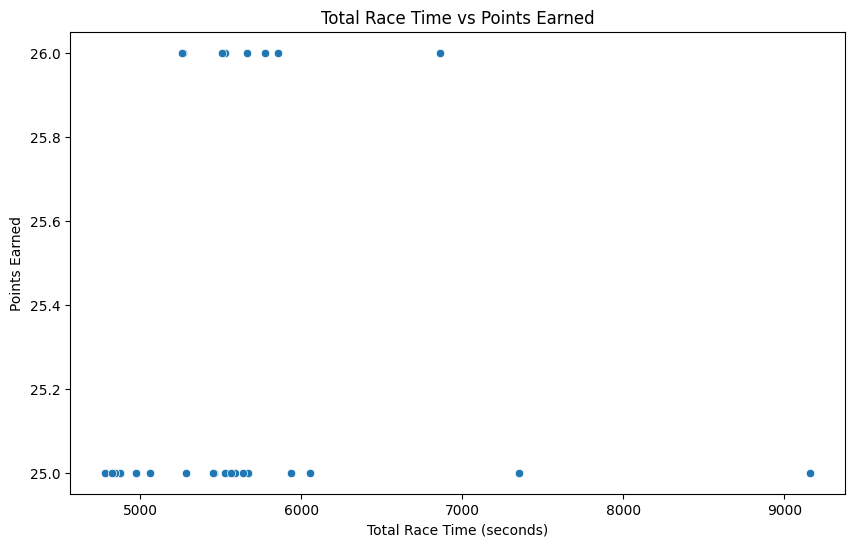

In [68]:
# Correlation Between Total Time and Points
plt.figure(figsize=(10, 6))
sns.scatterplot(x='totalTime', y='points', data=df)
plt.title('Total Race Time vs Points Earned')
plt.xlabel('Total Race Time (seconds)')
plt.ylabel('Points Earned')
plt.show()


# Average Points Earned per Driver by Circuit

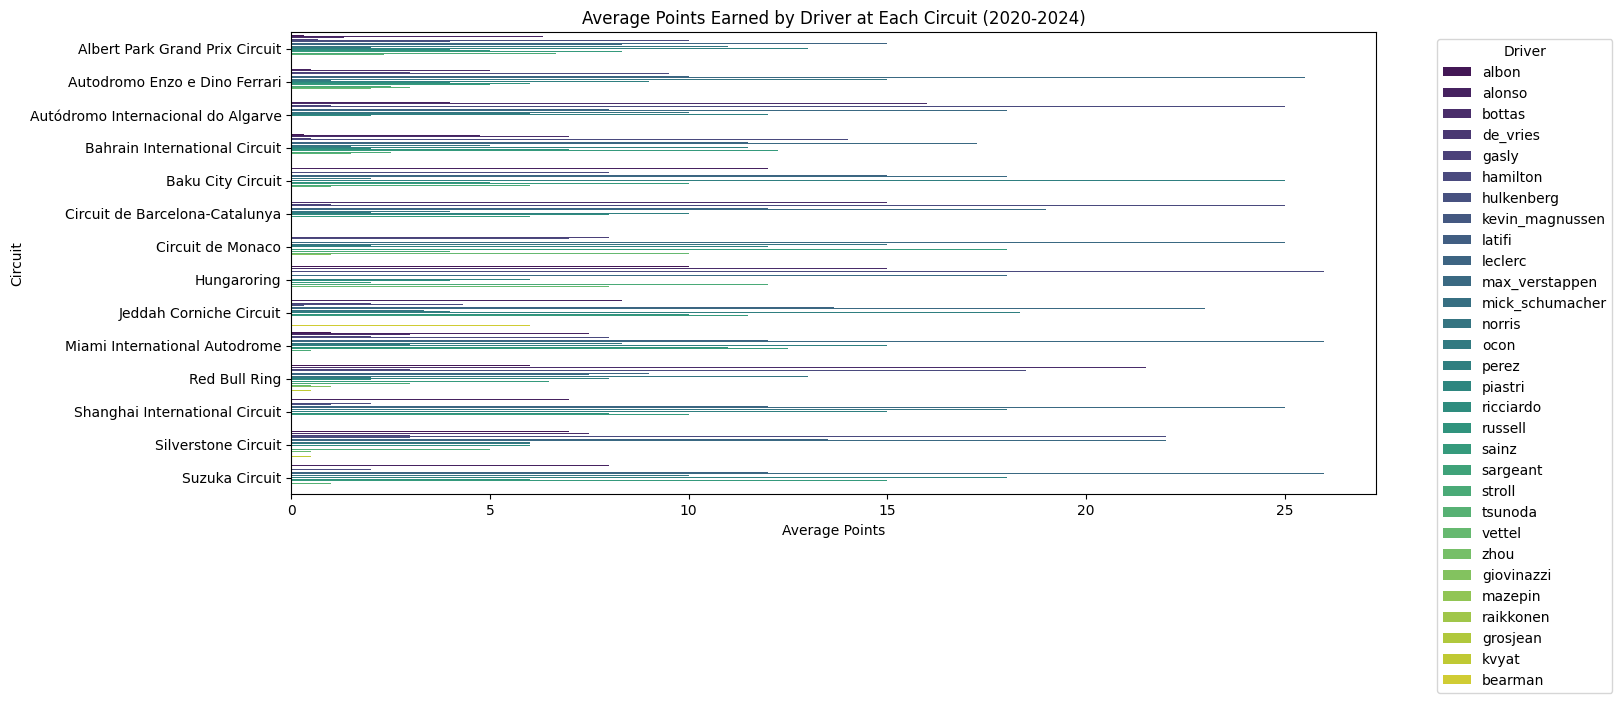

In [72]:
# Average Points Earned per Driver by Circuit
driver_circuit_performance = df.groupby(['circuitName', 'driverId'])['points'].mean().reset_index()

plt.figure(figsize=(14, 6))
sns.barplot(x='points', y='circuitName', hue='driverId', data=driver_circuit_performance, palette='viridis')
plt.title('Average Points Earned by Driver at Each Circuit (2020-2024)')
plt.xlabel('Average Points')
plt.ylabel('Circuit')
plt.legend(title='Driver', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# Trend of Points Over Time for Top 10 Drivers

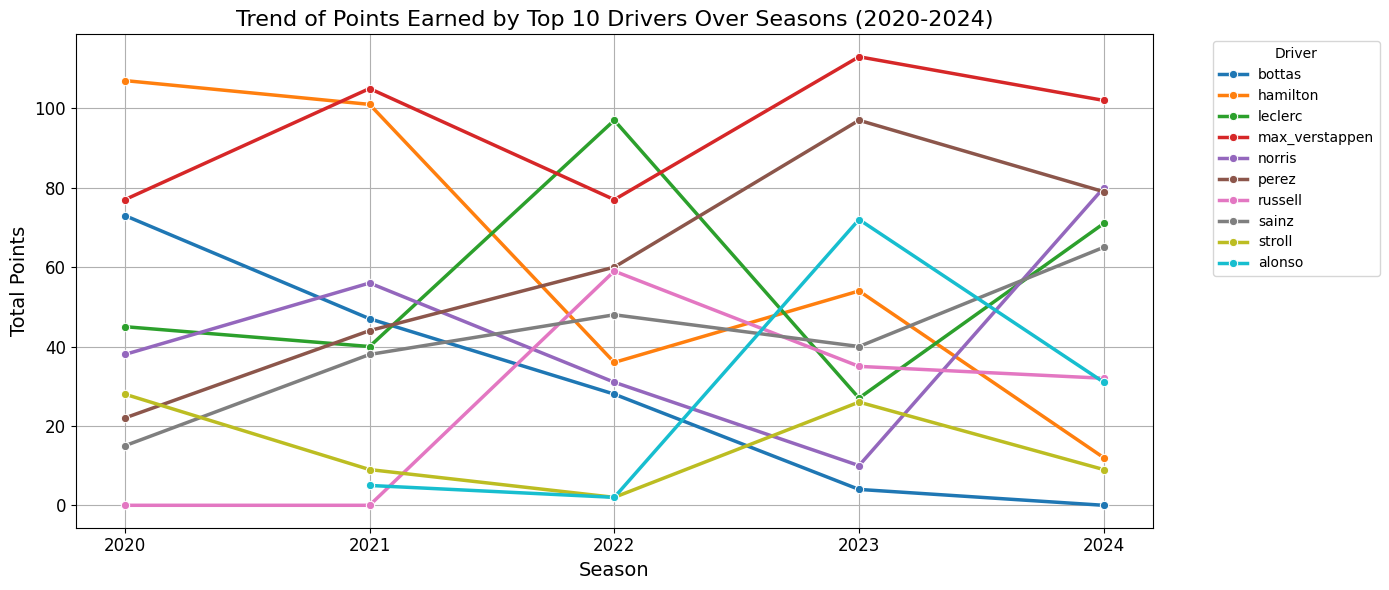

In [74]:

# Step 1: Calculate total points for each driver
total_points_per_driver = df.groupby('driverId')['points'].sum().reset_index()

# Step 2: Identify the top 10 drivers based on total points
top_drivers = total_points_per_driver.nlargest(10, 'points')['driverId']

# Step 3: Filter the original data for only the top 10 drivers
points_trend_top_drivers = df[df['driverId'].isin(top_drivers)].groupby(['season', 'driverId'])['points'].sum().reset_index()

# Step 4: Plotting the trend for the top 10 drivers
plt.figure(figsize=(14, 6))
sns.lineplot(data=points_trend_top_drivers, x='season', y='points', hue='driverId', marker='o', palette='tab10', linewidth=2.5)

plt.title('Trend of Points Earned by Top 10 Drivers Over Seasons (2020-2024)', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Total Points', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Driver', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
